In [1]:
import numpy as np
import scipy as sp
import os
import sys
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../src'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from s_pdap import SPDAP_Finite

# Heat Equation

## Generate Data and Define Functions

In [2]:
# Omega = np.array([[0,1]])
# alpha = 1e-5
# observation_resolution = 9
# std_factor = 0.02
# true_sources = np.array([[0.25], [0.57], [0.77]])
# true_weights = np.array([1, 0.7, -0.7])

# Omega = np.array([[0,1], [0,1]])
# alpha = 1e-1
# observation_resolution = 4
# std_factor = 0.1
# true_sources = np.array([[0.28, 0.31], [0.51,0.73]])
# true_weights = np.array([1,1])

Omega = np.array([[0,1], [0,1]])
alpha = 1e-1
observation_resolution = 4
std_factor = 0.1
true_sources = np.array([[0.28, 0.71], [0.51,0.27], [0.71,0.53]])
true_weights = np.array([1,-0.7, 0.8])

In [3]:
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])
k = lambda x: np.array([np.exp(-np.linalg.norm(point-x)**2/std_factor)/np.sqrt(std_factor*np.pi)**Omega.shape[0] for point in observations])
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(k)

In [4]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(sum(c * k(x) for x, c in zip(u.support, u.coefficients)) - target) ** 2

In [5]:
def p_raw(u, k, target):
    def p_u(x):
        Ku = u.duality_pairing(k)
        inner = Ku-target
        return -np.dot(inner, k(x))
    return p_u

p = lambda u: p_raw(u, k=k, target=target)

In [6]:
def grad_k_raw(observations, std_factor):
    def grad_k(x):
        return np.array([2*(point-x)*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]) for point in observations])
    return grad_k

grad_k = grad_k_raw(observations, std_factor) # The Jacobian of k, shape=(len(observations), Omega.shape[0])

In [7]:
def hess_k_raw(observations, std_factor):
    def hess_k(x):
        first_part = lambda point: -2*np.eye(Omega.shape[0])*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0])
        second_part = lambda point: 4*np.dot((point-x).reshape(-1,1), np.array([point-x]))*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0])
        return np.array([first_part(point)+second_part(point) for point in observations])
    return hess_k

hess_k = hess_k_raw(observations, std_factor) # The derivative of the Jacobian of k, shape=(len(observations), Omega.shape[0], Omega.shape[0])

In [8]:
def grad_P_raw(k, target, observations, std_factor):
    grad_k = grad_k_raw(observations, std_factor)
    def grad_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.sign(p_u(x))*np.matmul(grad_k(x).T, inner)
    return grad_P

grad_P = grad_P_raw(k, target, observations, std_factor)

In [9]:
def hess_P_raw(k, target, observations, std_factor):
    hess_k = hess_k_raw(observations, std_factor)
    def hess_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.sign(p_u(x))*np.tensordot(hess_k(x),inner,axes=([0,0]))
    return hess_P

hess_P = hess_P_raw(k, target, observations, std_factor)

In [10]:
def get_grad_j(k, grad_k, alpha, target):
    def grad_j(positions, coefs):
        to_return = []
        grad_F = (
            np.sum(
                np.array([c * k(x) for x, c in zip(positions, coefs)]),
                axis=0,
            )
            - target
        )
        for ind, x in enumerate(positions):
            # nabla_x_ind
            array = coefs[ind] * np.matmul(grad_k(x).T, grad_F)
            to_return += array.tolist()
        # nabla_u
        K = np.array([k(x) for x in positions])
        to_return += (np.dot(K, grad_F) + alpha * np.sign(coefs)).tolist()
        return np.array(to_return)
    return grad_j

grad_j = get_grad_j(k, grad_k, alpha, target)

In [11]:
def get_hess_j(k, grad_k, hess_k, target):
    def hess_j(positions, coefs):
        matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
        hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
        step = Omega.shape[0]
        coefs_delay = step*len(positions)
        inner = sum(k(x)*c for c, x in zip(coefs, positions))-target
        for i, position in enumerate(positions):
            # nabla_{x_i,x_j}
            for j, other_position in enumerate(positions):
                if j<i:
                    continue
                block = coefs[i]*coefs[j]*np.matmul(grad_k(position).T, grad_k(other_position))
                if i==j:
                    block += coefs[i]*np.tensordot(hess_k(position),inner,axes=([0,0]))
                hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
                hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
            # nabla_{x_i,u_j}
            for j, coef in enumerate(coefs):
                block = coefs[i]*np.matmul(grad_k(position).T, k(positions[j]))
                if i == j:
                    block += np.matmul(grad_k(position).T, inner)
                hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
                hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
        for i, coef in enumerate(coefs):
            # nabla_{u_i,u_j}
            for j, other_coef in enumerate(coefs):
                if j<i:
                    continue
                block = np.dot(k(positions[i]), k(positions[j]))
                hesse_matrix[coefs_delay+i,coefs_delay+j] = block
                hesse_matrix[coefs_delay+j,coefs_delay+i] = block
        return hesse_matrix
    return hess_j

hess_j = get_hess_j(k, grad_k, hess_k, target)

In [12]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = [np.linalg.norm(k(np.array([x]))) for x in a]
elif Omega.shape[0] == 2:
    B, D = np.meshgrid(a,a)
    vals = [np.linalg.norm(k(np.array([x_1,x_2]))) for x_1, x_2 in zip(B.flatten(), D.flatten())]
norm_K_star = max(vals) # ||k([0.5,0.5])||

In [13]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = [np.linalg.norm(grad_k(np.array([x]))) for x in a]
elif Omega.shape[0] == 2:
    B, D = np.meshgrid(a,a)
    vals = [np.linalg.norm(grad_k(np.array([x_1,x_2]))) for x_1, x_2 in zip(B.flatten(), D.flatten())]
norm_K_star_L = max(vals)

In [14]:
gamma = 0.5
theta = 1e-1
sigma = 2e-3
m = 1e-3
bar_m = 1e-1
L = 1
R = 1e-2

## Experiments

In [15]:
exp = LGCG(target=target, 
           k=k, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_K_star=norm_K_star,
           norm_K_star_L=norm_K_star_L,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           R=R
           )

In [23]:
u, P_values, times, supports, objective_values = exp.solve_exact(tol=1e-12)

DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:1: P_value:1.270E+01, support: [[0.44043758 0.69141257]], coefs: [1.05279812], x: [0.42427898 0.23939056]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:2: P_value:6.123E+00, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]], coefs: [-0.46886794  1.23385151], x: [0.83741191 0.49779621]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:3: P_value:4.981E+00, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741191 0.49779621]], coefs: [-0.53679209  1.13760922  0.3139453 ], x: [0.14118912 0.63968789]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:4: P_value:1.286E+00, support: [[0.141

In [24]:
times

[4.76837158203125e-07,
 1.1421022415161133,
 2.709259033203125,
 4.742556095123291,
 7.418776035308838,
 10.698617935180664,
 15.018169641494751,
 19.75955295562744,
 25.373873710632324,
 30.211089611053467,
 34.540101528167725,
 39.659963846206665,
 46.06420373916626,
 52.263530015945435,
 58.40088200569153,
 63.60793590545654,
 68.96459913253784,
 75.60568404197693,
 81.99317216873169,
 88.22258019447327,
 94.38863205909729,
 100.6277277469635,
 106.1830906867981,
 112.53582906723022,
 117.89811062812805,
 123.42859101295471,
 130.33456182479858,
 135.96046042442322,
 142.90534615516663,
 149.53271055221558,
 155.95592141151428,
 161.5651261806488,
 167.29910254478455,
 172.98654007911682,
 178.86833381652832,
 184.5873942375183,
 191.19315457344055,
 198.25101041793823,
 204.6906955242157,
 211.41328406333923,
 217.84447741508484,
 224.4280846118927,
 229.98019695281982,
 235.84946084022522,
 241.65241360664368,
 247.5549340248108,
 253.97585248947144,
 260.6898720264435,
 266.39742

In [25]:
supports

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 7,
 7,
 8,
 9,
 9,
 9,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 8,
 9,
 8,
 8,
 9,
 8,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 7,
 8,
 8,
 8,
 9,
 9,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 8,
 8,
 8,
 8,
 8,
 7,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9]

In [26]:
objective_values-boss

array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903638e+00,
       2.29592886e-01, 1.29111897e-01, 6.02585414e-02, 5.81289510e-02,
       5.43698661e-02, 4.28609943e-02, 2.43456497e-02, 2.24655442e-02,
       2.19692469e-02, 1.97512424e-02, 1.45352921e-02, 1.17524221e-02,
       8.37236281e-03, 8.03804004e-03, 7.27480849e-03, 5.49767060e-03,
       4.74499655e-03, 4.33283703e-03, 3.06984475e-03, 3.03428496e-03,
       2.57014255e-03, 2.25412175e-03, 2.23311087e-03, 1.77761518e-03,
       1.74648405e-03, 1.02712729e-03, 1.00858187e-03, 7.05156292e-04,
       4.57694094e-04, 3.73210929e-04, 3.33191232e-04, 3.26993815e-04,
       3.19893611e-04, 2.76247480e-04, 2.23202768e-04, 2.02451870e-04,
       1.54176449e-04, 1.15902756e-04, 8.63941081e-05, 6.07077161e-05,
       5.67249382e-05, 4.57642846e-05, 4.45976556e-05, 4.10299563e-05,
       3.04730730e-05, 1.81625899e-05, 1.30615438e-05, 1.09292938e-05,
       1.01601992e-05, 9.31935737e-06, 8.04471761e-06, 5.27239523e-06,
      

In [27]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322615 0.71433103]
 [0.28322801 0.7143322 ]
 [0.28322851 0.71433138]
 [0.49565793 0.23548633]
 [0.49565842 0.23548674]
 [0.49565873 0.23548586]
 [0.73058682 0.54790248]
 [0.7305882  0.54790095]
 [0.73058915 0.54790126]] and coefficients [ 0.49148472  0.12262213  0.38158459 -0.25034351 -0.10106152 -0.26617566
  0.12503683  0.29161565  0.29547973]
2.9101721032986916e-14
-2.3592239273284576e-15


In [16]:
u, grad_norms, times, supports, objective_values = exp.solve_newton(tol=1e-12, damped=False)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 2.548E-06
INFO:root:1: gcg, support: [[0.44043758 0.69141257]], coefs: [1.05279812], grad_norm:2.174E+01, objective: 5.807E+00
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 1.274E-06
INFO:root:2: gcg, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]], coefs: [-0.46886804  1.23385155], grad_norm:8.729E+00, objective: 2.829E+00
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 6.370E-07
INFO:root:3: gcg, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741189 0.49779617]], coefs: [-0.53679211  1.13760922  0.31394532], grad_norm:2.422E+01, objective: 1.868E+00
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 3.185E-07
INFO:root:4: gcg, support: [[0.14118912 0.63968788]
 [0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741189 0.49779617]], coefs: [ 0.56193763 -0.62011121  0.77396863  0.47872382], grad_norm:4.354E+00, objectiv

In [17]:
times

[7.152557373046875e-07,
 0.7667105197906494,
 2.0125412940979004,
 3.5806684494018555,
 5.685533761978149,
 8.273649215698242,
 11.726944923400879,
 16.331028699874878,
 21.34289050102234,
 27.06547784805298,
 32.101662158966064,
 36.82411766052246,
 42.323302268981934,
 48.996957778930664,
 55.3311231136322,
 61.619932413101196,
 67.21779704093933,
 72.68249130249023,
 78.93096566200256,
 85.38662147521973,
 92.03357410430908,
 98.33808779716492,
 104.45784902572632,
 110.03670692443848,
 116.6040244102478,
 122.15766143798828,
 127.71865344047546,
 134.25133180618286,
 139.83687376976013,
 146.18055772781372,
 152.49217867851257,
 156.36969351768494,
 158.45293545722961,
 160.52817010879517,
 162.87583327293396]

In [18]:
supports

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 7,
 7,
 8,
 9,
 9,
 9,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 8,
 9,
 8,
 8,
 9,
 8,
 9,
 9,
 6,
 3,
 3,
 3,
 3]

In [19]:
boss = objective_values[-1]

In [20]:
objective_values-boss

array([ 2.56626430e+01,  5.56767886e+00,  2.59016866e+00,  1.62903642e+00,
        2.29592990e-01,  1.29111932e-01,  6.02585534e-02,  5.81289612e-02,
        5.43698732e-02,  4.28609927e-02,  2.43456071e-02,  2.24655088e-02,
        2.19692084e-02,  1.97512141e-02,  1.45352676e-02,  1.17524038e-02,
        8.37239883e-03,  8.03808359e-03,  7.27483455e-03,  5.49772553e-03,
        4.74502395e-03,  4.33287730e-03,  3.06986962e-03,  3.03430965e-03,
        2.57016097e-03,  2.25416046e-03,  2.23314682e-03,  1.77758066e-03,
        1.74647234e-03,  1.02710276e-03,  2.10966344e-05,  1.51057950e-05,
        2.82708607e-10, -2.77555756e-17,  0.00000000e+00])

In [21]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
1.1102230246251565e-15
3.0531133177191805e-16


In [22]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([402.39077637, 272.29702435, 194.35314107,  68.45550406,
        48.27005106,   1.82700374,   7.42624617,  18.87504406,
        24.25981579])

In [28]:
u, grad_norms, times, supports, objective_values = exp.solve_newton(tol=1e-12, damped=True)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 2.548E-06
INFO:root:1: gcg, support: [[0.44043758 0.69141257]], coefs: [1.05279812], grad_norm:2.174E+01, objective: 5.807E+00
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 1.274E-06
INFO:root:2: gcg, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]], coefs: [-0.46886804  1.23385155], grad_norm:8.729E+00, objective: 2.829E+00
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 6.370E-07
INFO:root:3: gcg, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741189 0.49779617]], coefs: [-0.53679211  1.13760922  0.31394532], grad_norm:2.422E+01, objective: 1.868E+00
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 2.548E-06
INFO:root:4: newton, support: [[0.41382093 0.66314804]
 [0.45918859 0.31637916]
 [0.87381301 0.50175144]], coefs: [ 1.25186813 -0.66351344  0.48339649], grad_norm:1.817E+01, objective: 1.087E+00
DEBUG:root:SSN in 3 d

In [29]:
times

[4.76837158203125e-07,
 0.5382094383239746,
 1.5421593189239502,
 3.0603673458099365,
 4.962559700012207,
 7.074236869812012,
 9.139989376068115,
 11.206842422485352,
 13.278956890106201,
 15.516653776168823,
 17.851645708084106,
 20.00382375717163,
 22.107034921646118,
 24.32866668701172,
 26.55902600288391,
 28.62384605407715,
 30.583699941635132,
 32.713337421417236,
 34.892345905303955,
 37.02305579185486,
 39.158655643463135,
 41.31588792800903]

In [30]:
supports

[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [31]:
objective_values-boss

array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903642e+00,
       8.47728956e-01, 6.70798629e-01, 5.29852103e-01, 4.12011062e-01,
       3.11021042e-01, 2.24405755e-01, 1.52490459e-01, 9.63926672e-02,
       5.59330909e-02, 2.91602755e-02, 1.31493710e-02, 4.79875730e-03,
       1.25693718e-03, 1.86690389e-04, 9.35660829e-06, 4.58474392e-08,
       1.44018131e-12, 2.77555756e-17])

In [32]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
3.4139358007223564e-15
3.3861802251067274e-15


In [33]:
u, Phi_ks, times, supports, objective_values = exp.solve(tol=1e-12)

INFO:root:1: N/A, Phi_k: 381.74392262753315, epsilon: 393.73810553231726 support: []
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 2.548E-06
INFO:root:True Psi: 2.025E-14
INFO:root:2: GCG, False, Phi_k: 127.0084785361519, epsilon: 497.8139826983301 support: [[0.44043758 0.69141257]]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 2.548E-06
INFO:root:True Psi: 3.073E-06
INFO:root:3: GCG, False, Phi_k: 61.22929458199645, epsilon: 507.9913326709468 support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 2.548E-06
INFO:root:True Psi: 2.285E-06
INFO:root:4: GCG, False, Phi_k: 49.80779560732292, epsilon: 486.3604140778353 support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741188 0.49779613]]


In [38]:
np.array(times)

array([7.15255737e-07, 6.56994820e-01, 1.76031137e+00, 3.73558021e+00,
       5.79388428e+00, 8.51514983e+00, 1.18479843e+01, 1.60145929e+01,
       2.01414709e+01, 2.44199047e+01, 2.90065122e+01, 3.36157348e+01,
       3.85809641e+01, 4.41950800e+01, 4.91044450e+01, 5.39190013e+01,
       5.83688645e+01, 6.38161383e+01, 6.99752748e+01, 7.64774971e+01,
       8.29637578e+01, 8.96812816e+01, 9.62571192e+01, 1.02399684e+02,
       1.08517256e+02, 1.14679425e+02, 1.20834211e+02, 1.29129638e+02,
       1.36600508e+02, 1.43620188e+02, 1.49845252e+02, 1.56457193e+02,
       1.62604197e+02, 1.68838461e+02, 1.75395849e+02, 1.81182960e+02,
       1.87413422e+02, 1.94021937e+02, 1.99452609e+02, 2.05027024e+02,
       2.10451323e+02, 2.17432488e+02, 2.24164201e+02, 2.29792510e+02,
       2.36679241e+02, 2.43172314e+02, 2.49886778e+02, 2.56723117e+02,
       2.63538392e+02, 2.69279823e+02, 2.75117072e+02, 2.80728533e+02,
       2.86316186e+02, 2.91912647e+02, 2.97754307e+02, 3.03272538e+02,
      

In [39]:
np.array(supports)

array([ 0,  0,  1,  2,  3,  4,  5,  6,  6,  6,  7,  7,  7,  8,  7,  7,  7,
        8,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
        8,  8,  8,  9,  8,  8,  8,  9,  9,  8,  9,  9,  9,  9,  9,  8,  8,
        8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  8,
        8,  8,  9,  9,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  8,  8,  9,  9,  8,  9,  8,  8,  9,  8,  8,  8,  8,  8,  9,  9,
        9,  8,  8,  8,  8,  9,  9,  9,  8,  8,  8,  8,  8,  9,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9, 10, 11])

In [36]:
objective_values-boss

array([2.56626430e+01, 2.56626430e+01, 5.56767886e+00, 2.59016866e+00,
       1.62903645e+00, 2.29593104e-01, 1.29111984e-01, 6.02585726e-02,
       6.02585726e-02, 6.02585726e-02, 5.81289766e-02, 5.81289766e-02,
       5.81289766e-02, 5.43698854e-02, 4.28609923e-02, 4.28609923e-02,
       2.43455659e-02, 2.24654750e-02, 2.19691709e-02, 2.19691709e-02,
       2.19691709e-02, 1.97511872e-02, 1.97511872e-02, 1.45352424e-02,
       1.17523847e-02, 1.17523847e-02, 1.17523847e-02, 8.37243246e-03,
       8.03812426e-03, 7.27485886e-03, 7.27485886e-03, 5.49777830e-03,
       4.74504977e-03, 4.33291569e-03, 3.06989322e-03, 3.06989322e-03,
       3.06989322e-03, 3.03433308e-03, 2.57017840e-03, 2.57017840e-03,
       2.25419754e-03, 2.23318127e-03, 2.23318127e-03, 1.77754799e-03,
       1.74646136e-03, 1.74646136e-03, 1.02707906e-03, 1.00857314e-03,
       1.00857314e-03, 7.05214770e-04, 7.05214770e-04, 4.57750509e-04,
       4.57750509e-04, 3.73035491e-04, 3.33280804e-04, 3.33280804e-04,
      

In [37]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322687 0.71433112]
 [0.28322727 0.71433142]
 [0.28322766 0.71433103]
 [0.49565818 0.23548643]
 [0.49565835 0.23548593]
 [0.49565845 0.23548613]
 [0.73058738 0.54790213]
 [0.73058756 0.54790164]
 [0.73058782 0.54790167]
 [0.73058784 0.54790166]
 [0.73058852 0.54790121]] and coefficients [ 1.26471731e-01  7.24715960e-01  1.44503738e-01 -1.62549857e-01
 -4.08662914e-04 -4.54622194e-01  5.01164287e-02  5.32496597e-02
  3.09942111e-03  3.40024750e-02  5.71664299e-01]
8.108791416105987e-14
2.961519918187605e-14


## Plots

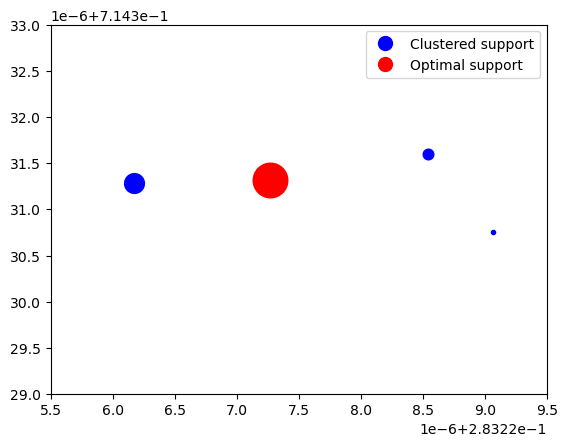

In [26]:
clustered_points = [[0.28322617, 0.71433129], [0.28322854, 0.7143316], [0.28322907, 0.71433075]]
clustered_weights = [0.57002759,  0.30609638,  0.11956745]
true_point = [0.28322727, 0.71433132]
true_weight = 0.99569143
plt.plot(0,0,"o", c="b", markersize=10,label="Clustered support"); # Point for legend
plt.plot(0,0,"o", c="r", markersize=10,label="Optimal support"); # Point for legend
for (x,c) in zip(clustered_points, clustered_weights):
    plt.plot(x[0], x[1], "o", c="b", markersize=25*c);
plt.plot(true_point[0], true_point[1], "o", c="r", markersize=25*true_weight);
plt.ylim(7.14331e-1-2e-6, 7.14331e-1+2e-6)
plt.xlim(2.832275e-1-2e-6, 2.832275e-1+2e-6)
plt.legend(fontsize=10);

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f4a0448afb0>


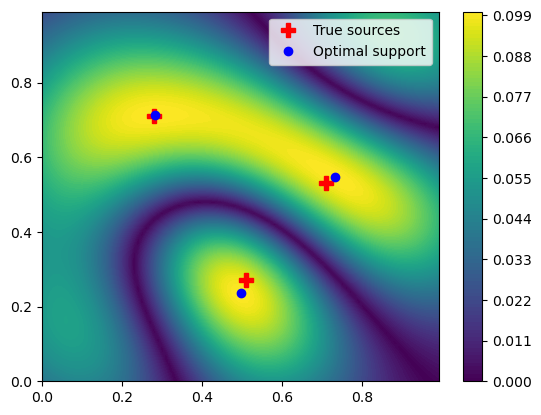

In [47]:
u_tilde = u # Measure(support=[[0.15726501,0.32474335]], coefficients=[0.8985414])
P = lambda x: np.abs(p(u_tilde)(x))
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((100,100))

plt.contourf(B, D, vals, levels=100);
plt.colorbar();
for i, x in enumerate(true_sources):
    if i:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10);
    else:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10, label="True sources");
for i, x in enumerate(u_tilde.support):
    if i:
        plt.plot([x[0]], [x[1]], "o", c="b");
    else:
        plt.plot([x[0]], [x[1]], "o", c="b", label="Optimal support");
plt.legend();

In [ ]:
residuals_exact = np.array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903638e+00,
       2.29592886e-01, 1.29111897e-01, 6.02585414e-02, 5.81289510e-02,
       5.43698661e-02, 4.28609943e-02, 2.43456497e-02, 2.24655442e-02,
       2.19692469e-02, 1.97512424e-02, 1.45352921e-02, 1.17524221e-02,
       8.37236281e-03, 8.03804004e-03, 7.27480849e-03, 5.49767060e-03,
       4.74499655e-03, 4.33283703e-03, 3.06984475e-03, 3.03428496e-03,
       2.57014255e-03, 2.25412175e-03, 2.23311087e-03, 1.77761518e-03,
       1.74648405e-03, 1.02712729e-03, 1.00858187e-03, 7.05156292e-04,
       4.57694094e-04, 3.73210929e-04, 3.33191232e-04, 3.26993815e-04,
       3.19893611e-04, 2.76247480e-04, 2.23202768e-04, 2.02451870e-04,
       1.54176449e-04, 1.15902756e-04, 8.63941081e-05, 6.07077161e-05,
       5.67249382e-05, 4.57642846e-05, 4.45976556e-05, 4.10299563e-05,
       3.04730730e-05, 1.81625899e-05, 1.30615438e-05, 1.09292938e-05,
       1.01601992e-05, 9.31935737e-06, 8.04471761e-06, 5.27239523e-06,
       4.24388700e-06, 3.14460100e-06, 2.27118929e-06, 2.09966320e-06,
       1.54891121e-06, 1.32246736e-06, 1.21785029e-06, 7.00887454e-07,
       5.12615817e-07, 4.96090635e-07, 2.82284871e-07, 2.65907146e-07,
       2.43542073e-07, 2.04637083e-07, 1.51814960e-07, 1.42743968e-07,
       1.19945281e-07, 1.02223943e-07, 8.51085699e-08, 6.47779335e-08,
       4.07110811e-08, 3.04123352e-08, 2.81188449e-08, 2.70938070e-08,
       1.82861264e-08, 1.62962913e-08, 1.49475342e-08, 1.41934689e-08,
       1.04305286e-08, 9.21750959e-09, 8.98143040e-09, 4.33840025e-09,
       3.96065764e-09, 3.49422369e-09, 3.30505220e-09, 2.54478352e-09,
       1.26954885e-09, 1.15724891e-09, 8.77014600e-10, 7.13043680e-10,
       6.65814820e-10, 5.81222792e-10, 4.70454481e-10, 4.22373581e-10,
       3.54919427e-10, 2.61715954e-10, 2.16951651e-10, 2.12305895e-10,
       1.60055913e-10, 1.36245959e-10, 1.02627629e-10, 9.73942871e-11,
       7.49746099e-11, 6.24263974e-11, 5.72206171e-11, 3.41127127e-11,
       2.60852728e-11, 2.53670140e-11, 2.01858807e-11, 1.93184635e-11,
       1.58970614e-11, 7.87622745e-12, 5.46176993e-12, 5.13972198e-12,
       4.27929914e-12, 2.94236857e-12, 2.83040258e-12, 2.72099010e-12,
       2.41556775e-12, 2.13476459e-12, 1.92248995e-12, 1.43071666e-12,
       1.36343714e-12, 1.12818088e-12])

times_exact = np.array([4.76837158e-07, 1.14210224e+00, 2.70925903e+00, 4.74255610e+00,
       7.41877604e+00, 1.06986179e+01, 1.50181696e+01, 1.97595530e+01,
       2.53738737e+01, 3.02110896e+01, 3.45401015e+01, 3.96599638e+01,
       4.60642037e+01, 5.22635300e+01, 5.84008820e+01, 6.36079359e+01,
       6.89645991e+01, 7.56056840e+01, 8.19931722e+01, 8.82225802e+01,
       9.43886321e+01, 1.00627728e+02, 1.06183091e+02, 1.12535829e+02,
       1.17898111e+02, 1.23428591e+02, 1.30334562e+02, 1.35960460e+02,
       1.42905346e+02, 1.49532711e+02, 1.55955921e+02, 1.61565126e+02,
       1.67299103e+02, 1.72986540e+02, 1.78868334e+02, 1.84587394e+02,
       1.91193155e+02, 1.98251010e+02, 2.04690696e+02, 2.11413284e+02,
       2.17844477e+02, 2.24428085e+02, 2.29980197e+02, 2.35849461e+02,
       2.41652414e+02, 2.47554934e+02, 2.53975852e+02, 2.60689872e+02,
       2.66397430e+02, 2.72305648e+02, 2.78885815e+02, 2.84960662e+02,
       2.90672310e+02, 2.97727157e+02, 3.04464915e+02, 3.11395301e+02,
       3.17954890e+02, 3.24360248e+02, 3.31521899e+02, 3.38432771e+02,
       3.45139485e+02, 3.51486623e+02, 3.58289957e+02, 3.64734979e+02,
       3.71417867e+02, 3.77982733e+02, 3.83967288e+02, 3.90069675e+02,
       3.96030845e+02, 4.01869496e+02, 4.07604819e+02, 4.14631508e+02,
       4.21611674e+02, 4.27964765e+02, 4.34014118e+02, 4.39823160e+02,
       4.46143695e+02, 4.52298251e+02, 4.57509923e+02, 4.63572303e+02,
       4.69971073e+02, 4.75552535e+02, 4.82291310e+02, 4.88789125e+02,
       4.94531506e+02, 5.00128260e+02, 5.06560030e+02, 5.13394951e+02,
       5.20236441e+02, 5.27104015e+02, 5.34015042e+02, 5.40762053e+02,
       5.46778672e+02, 5.52981607e+02, 5.59100137e+02, 5.64861600e+02,
       5.70471639e+02, 5.75919909e+02, 5.82095361e+02, 5.88561360e+02,
       5.95185043e+02, 6.02303921e+02, 6.08911485e+02, 6.15510429e+02,
       6.22262479e+02, 6.29060690e+02, 6.35739551e+02, 6.42447977e+02,
       6.48920088e+02, 6.54928286e+02, 6.61015720e+02, 6.66871667e+02,
       6.72657016e+02, 6.78691621e+02, 6.84549294e+02, 6.90674835e+02,
       6.96454134e+02, 7.01973755e+02, 7.07307206e+02, 7.12713768e+02,
       7.18457867e+02, 7.23339051e+02, 7.29424068e+02, 7.36322444e+02,
       7.43187184e+02, 7.50007147e+02, 7.56319950e+02, 7.62745409e+02,
       7.69200324e+02, 7.76097054e+02])

supports_exact = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 8, 9, 9, 8, 8, 9, 9,
       9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8,
       8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 7, 8, 9, 9, 9, 9, 9, 9, 9])

residuals_newton = np.array([ 2.56626430e+01,  5.56767886e+00,  2.59016866e+00,  1.62903642e+00,
        2.29592990e-01,  1.29111932e-01,  6.02585534e-02,  5.81289612e-02,
        5.43698732e-02,  4.28609927e-02,  2.43456071e-02,  2.24655088e-02,
        2.19692084e-02,  1.97512141e-02,  1.45352676e-02,  1.17524038e-02,
        8.37239883e-03,  8.03808359e-03,  7.27483455e-03,  5.49772553e-03,
        4.74502395e-03,  4.33287730e-03,  3.06986962e-03,  3.03430965e-03,
        2.57016097e-03,  2.25416046e-03,  2.23314682e-03,  1.77758066e-03,
        1.74647234e-03,  1.02710276e-03,  2.10966344e-05,  1.51057950e-05,
        2.82708607e-10, -2.77555756e-17,  0.00000000e+00])

times_newton = np.array([7.15255737e-07, 7.66710520e-01, 2.01254129e+00, 3.58066845e+00,
       5.68553376e+00, 8.27364922e+00, 1.17269449e+01, 1.63310287e+01,
       2.13428905e+01, 2.70654778e+01, 3.21016622e+01, 3.68241177e+01,
       4.23233023e+01, 4.89969578e+01, 5.53311231e+01, 6.16199324e+01,
       6.72177970e+01, 7.26824913e+01, 7.89309657e+01, 8.53866215e+01,
       9.20335741e+01, 9.83380878e+01, 1.04457849e+02, 1.10036707e+02,
       1.16604024e+02, 1.22157661e+02, 1.27718653e+02, 1.34251332e+02,
       1.39836874e+02, 1.46180558e+02, 1.52492179e+02, 1.56369694e+02,
       1.58452935e+02, 1.60528170e+02, 1.62875833e+02])

supports_newton = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 6, 3, 3, 3, 3])

residuals_newton_damped = np.array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903642e+00,
       8.47728956e-01, 6.70798629e-01, 5.29852103e-01, 4.12011062e-01,
       3.11021042e-01, 2.24405755e-01, 1.52490459e-01, 9.63926672e-02,
       5.59330909e-02, 2.91602755e-02, 1.31493710e-02, 4.79875730e-03,
       1.25693718e-03, 1.86690389e-04, 9.35660829e-06, 4.58474392e-08,
       1.44018131e-12, 2.77555756e-17])

times_newton_damped = np.array([4.76837158e-07, 5.38209438e-01, 1.54215932e+00, 3.06036735e+00,
       4.96255970e+00, 7.07423687e+00, 9.13998938e+00, 1.12068424e+01,
       1.32789569e+01, 1.55166538e+01, 1.78516457e+01, 2.00038238e+01,
       2.21070349e+01, 2.43286667e+01, 2.65590260e+01, 2.86238461e+01,
       3.05836999e+01, 3.27133374e+01, 3.48923459e+01, 3.70230558e+01,
       3.91586556e+01, 4.13158879e+01])

supports_newton_damped = np.array([0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

residuals_lpdap = np.array([2.56626430e+01, 2.56626430e+01, 5.56767886e+00, 2.59016866e+00,
       1.62903645e+00, 2.29593104e-01, 1.29111984e-01, 6.02585726e-02,
       6.02585726e-02, 6.02585726e-02, 5.81289766e-02, 5.81289766e-02,
       5.81289766e-02, 5.43698854e-02, 4.28609923e-02, 4.28609923e-02,
       2.43455659e-02, 2.24654750e-02, 2.19691709e-02, 2.19691709e-02,
       2.19691709e-02, 1.97511872e-02, 1.97511872e-02, 1.45352424e-02,
       1.17523847e-02, 1.17523847e-02, 1.17523847e-02, 8.37243246e-03,
       8.03812426e-03, 7.27485886e-03, 7.27485886e-03, 5.49777830e-03,
       4.74504977e-03, 4.33291569e-03, 3.06989322e-03, 3.06989322e-03,
       3.06989322e-03, 3.03433308e-03, 2.57017840e-03, 2.57017840e-03,
       2.25419754e-03, 2.23318127e-03, 2.23318127e-03, 1.77754799e-03,
       1.74646136e-03, 1.74646136e-03, 1.02707906e-03, 1.00857314e-03,
       1.00857314e-03, 7.05214770e-04, 7.05214770e-04, 4.57750509e-04,
       4.57750509e-04, 3.73035491e-04, 3.33280804e-04, 3.33280804e-04,
       3.27077591e-04, 3.19989623e-04, 3.19989623e-04, 2.76573620e-04,
       2.22966500e-04, 2.22966500e-04, 2.02052919e-04, 1.53862263e-04,
       1.53862263e-04, 1.15135464e-04, 8.57184256e-05, 6.10054059e-05,
       5.67658197e-05, 4.60860955e-05, 4.49142974e-05, 4.12155401e-05,
       3.02952868e-05, 1.79040152e-05, 1.29900430e-05, 1.09690283e-05,
       1.00183071e-05, 9.17368427e-06, 8.12586663e-06, 5.21687053e-06,
       4.25289672e-06, 3.24520055e-06, 2.32697065e-06, 2.07459127e-06,
       1.55278554e-06, 1.28782252e-06, 1.12934145e-06, 6.63472203e-07,
       5.61692291e-07, 5.37050071e-07, 3.27587596e-07, 2.31591514e-07,
       1.94387331e-07, 1.14554176e-07, 6.64286857e-08, 2.59295253e-08,
       2.23065530e-08, 7.46609927e-09, 5.88896623e-09, 3.20444246e-09,
       1.96830649e-09, 1.57393881e-09, 1.16127896e-09, 4.80090051e-10,
       3.55454804e-10, 2.65969052e-10, 1.43434653e-10, 1.41829354e-10,
       8.81628381e-11, 4.49319193e-11, 4.04348777e-11, 3.70721231e-11,
       2.04931627e-11, 1.40691070e-11, 1.08997533e-11, 5.77213277e-12,
       3.43075568e-12, 3.15023008e-12, 2.19979590e-12, 2.00950367e-12,
       1.65784053e-12, 1.14158683e-12, 1.01396669e-12, 4.98906472e-13,
       2.13801199e-13, 1.50296442e-13, 1.24761312e-13, 1.19265708e-13,
       1.18322019e-13])

times_lpdap = np.array([7.15255737e-07, 6.56994820e-01, 1.76031137e+00, 3.73558021e+00,
       5.79388428e+00, 8.51514983e+00, 1.18479843e+01, 1.60145929e+01,
       2.01414709e+01, 2.44199047e+01, 2.90065122e+01, 3.36157348e+01,
       3.85809641e+01, 4.41950800e+01, 4.91044450e+01, 5.39190013e+01,
       5.83688645e+01, 6.38161383e+01, 6.99752748e+01, 7.64774971e+01,
       8.29637578e+01, 8.96812816e+01, 9.62571192e+01, 1.02399684e+02,
       1.08517256e+02, 1.14679425e+02, 1.20834211e+02, 1.29129638e+02,
       1.36600508e+02, 1.43620188e+02, 1.49845252e+02, 1.56457193e+02,
       1.62604197e+02, 1.68838461e+02, 1.75395849e+02, 1.81182960e+02,
       1.87413422e+02, 1.94021937e+02, 1.99452609e+02, 2.05027024e+02,
       2.10451323e+02, 2.17432488e+02, 2.24164201e+02, 2.29792510e+02,
       2.36679241e+02, 2.43172314e+02, 2.49886778e+02, 2.56723117e+02,
       2.63538392e+02, 2.69279823e+02, 2.75117072e+02, 2.80728533e+02,
       2.86316186e+02, 2.91912647e+02, 2.97754307e+02, 3.03272538e+02,
       3.08919601e+02, 3.15818144e+02, 3.22616422e+02, 3.28982685e+02,
       3.35674496e+02, 3.42821238e+02, 3.49554759e+02, 3.56267743e+02,
       3.62674067e+02, 3.69503080e+02, 3.75326048e+02, 3.81274620e+02,
       3.87177607e+02, 3.92811242e+02, 3.99744123e+02, 4.06403989e+02,
       4.11960164e+02, 4.17751319e+02, 4.23355481e+02, 4.28847142e+02,
       4.34576087e+02, 4.41301504e+02, 4.48428518e+02, 4.55143880e+02,
       4.62124284e+02, 4.69022979e+02, 4.75752274e+02, 4.82506945e+02,
       4.89112908e+02, 4.95729842e+02, 5.01731086e+02, 5.07515462e+02,
       5.15454404e+02, 5.22527961e+02, 5.28054398e+02, 5.34911939e+02,
       5.40606335e+02, 5.46941439e+02, 5.54181724e+02, 5.60698966e+02,
       5.66676629e+02, 5.72982821e+02, 5.78988151e+02, 5.85087353e+02,
       5.91699803e+02, 5.98789187e+02, 6.05660110e+02, 6.11523337e+02,
       6.17744163e+02, 6.23511200e+02, 6.29244887e+02, 6.36114805e+02,
       6.43134926e+02, 6.50447225e+02, 6.56293836e+02, 6.62471096e+02,
       6.68336115e+02, 6.74343685e+02, 6.80626625e+02, 6.87706765e+02,
       6.94051748e+02, 6.99859324e+02, 7.05493194e+02, 7.11871898e+02,
       7.17675061e+02, 7.23508674e+02, 7.30507067e+02, 7.37614683e+02,
       7.44345739e+02, 7.50907922e+02, 7.57498062e+02, 7.65322376e+02,
       7.73805350e+02])

supports_lpdap = np.array([ 0,  0,  1,  2,  3,  4,  5,  6,  6,  6,  7,  7,  7,  8,  7,  7,  7,
        8,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
        8,  8,  8,  9,  8,  8,  8,  9,  9,  8,  9,  9,  9,  9,  9,  8,  8,
        8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  8,
        8,  8,  9,  9,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  8,  8,  9,  9,  8,  9,  8,  8,  9,  8,  8,  8,  8,  8,  9,  9,
        9,  8,  8,  8,  8,  9,  9,  9,  8,  8,  8,  8,  8,  9,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9, 10, 11])

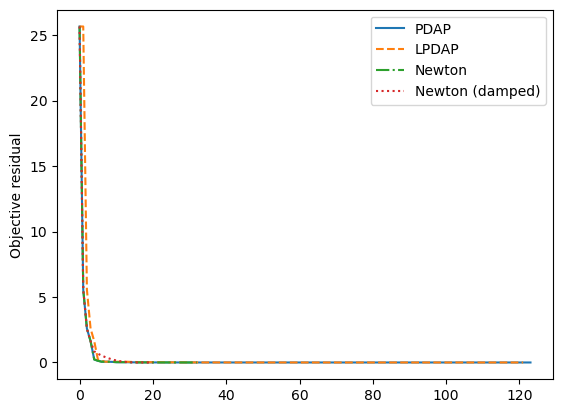

In [7]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
for array, name, style in zip([residuals_exact, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-12, 26);
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
for array, name, style in zip([supports_exact, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
for domain, array, name, style in zip([times_exact, times_lpdap, times_newton, times_newton_damped], [residuals_exact, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-12, 26);
plt.legend();

# Signal Processing

## Generate Data and Define Functions

In [2]:
observation_resolution = 30
Omega = np.array([[0,observation_resolution//2]])
alpha = 1e-1
true_sources = np.array([[3.125], [7], [np.sqrt(179)]])
true_weights = np.array([-1, 0.7, 0.5])

In [3]:
observations = np.arange(0,1,1/observation_resolution)
k = lambda x: np.array([np.sin(2*np.pi*x[0]*t) for t in observations])
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(k)

In [4]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(k) - target) ** 2

In [5]:
def p_raw(u, k, target):
    def p_u(x):
        Ku = u.duality_pairing(k)
        inner = Ku-target
        return -np.dot(inner, k(x))
    return p_u

p = lambda u: p_raw(u, k=k, target=target)

In [6]:
def grad_k_raw(observations):
    def grad_k(x):
        return np.array([[2*np.pi*t*np.cos(2*np.pi*x[0]*t) for t in observations]]).T
    return grad_k

grad_k = grad_k_raw(observations) # The Jacobian of k, shape=(len(observations),Omega.shape[0])

In [7]:
def hess_k_raw(observations):
    def hess_k(x):
        return np.transpose(np.array([[[-4*np.pi**2*t**2*np.sin(2*np.pi*x[0]*t) for t in observations]]]), axes=(2,0,1))
    return hess_k

hess_k = hess_k_raw(observations) # The Hessian of k, shape=(len(observations),Omega.shape[0],Omega.shape[0])

In [8]:
def grad_P_raw(k, target, observations):
    grad_k = grad_k_raw(observations)
    def grad_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.array(np.sign(p_u(x))*np.matmul(grad_k(x).T, inner))
    return grad_P

grad_P = grad_P_raw(k, target, observations)

In [9]:
def hess_P_raw(k, target, observations):
    hess_k = hess_k_raw(observations)
    def hess_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.array(np.sign(p_u(x))*np.tensordot(hess_k(x),inner,axes=([0,0])))
    return hess_P

hess_P = hess_P_raw(k, target, observations)

In [10]:
def get_grad_j(k, grad_k, alpha, target):
    def grad_j(positions, coefs):
        to_return = []
        grad_F = (
            np.sum(
                np.array([c * k(x) for x, c in zip(positions, coefs)]),
                axis=0,
            )
            - target
        )
        for ind, x in enumerate(positions):
            # nabla_x_ind
            array = coefs[ind] * np.matmul(grad_k(x).T, grad_F)
            to_return += array.tolist()
        # nabla_u
        K = np.array([k(x) for x in positions])
        to_return += (np.dot(K, grad_F) + alpha * np.sign(coefs)).tolist()
        return np.array(to_return)
    return grad_j

grad_j = get_grad_j(k, grad_k, alpha, target)

In [11]:
def get_hess_j(k, grad_k, hess_k, target):
    def hess_j(positions, coefs):
        matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
        hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
        step = Omega.shape[0]
        coefs_delay = step*len(positions)
        inner = sum(k(x)*c for c, x in zip(coefs, positions))-target
        for i, position in enumerate(positions):
            # nabla_{x_i,x_j}
            for j, other_position in enumerate(positions):
                if j<i:
                    continue
                block = coefs[i]*coefs[j]*np.matmul(grad_k(position).T, grad_k(other_position))
                if i==j:
                    block += coefs[i]*np.tensordot(hess_k(position),inner,axes=([0,0]))
                hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
                hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
            # nabla_{x_i,u_j}
            for j, coef in enumerate(coefs):
                block = coefs[i]*np.matmul(grad_k(position).T, k(positions[j]))
                if i == j:
                    block += np.matmul(grad_k(position).T, inner)
                hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
                hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
        for i, coef in enumerate(coefs):
            # nabla_{u_i,u_j}
            for j, other_coef in enumerate(coefs):
                if j<i:
                    continue
                block = np.dot(k(positions[i]), k(positions[j]))
                hesse_matrix[coefs_delay+i,coefs_delay+j] = block
                hesse_matrix[coefs_delay+j,coefs_delay+i] = block
        return hesse_matrix
    return hess_j

hess_j = get_hess_j(k, grad_k, hess_k, target)

In [12]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1)
vals = [np.linalg.norm(k(np.array([x]))) for x in a]
norm_K_star = max(vals)

In [13]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1)
vals = [np.linalg.norm(grad_k(np.array([x]))) for x in a]
norm_K_star_L = max(vals)

In [14]:
gamma = 0.5
theta = 1e-1
sigma = 5e-2
m = 1e-3
bar_m = 1e-1
L = 1
R = 1e-1

In [15]:
class FeatureResponse:
    def __init__(self, value):
        self.phi = value

class Feature:
    def __init__(self, value: np.ndarray, expression: float):
        self.value = value
        self.expr = expression
    

def feature_generator(domain, sample_size, kernel):
    def inner_generator():
        omega_sample = [random.uniform(domain[0], domain[1]) for _ in range(sample_size)]
        features = [kernel([position]) for position in omega_sample]
        response_value = [Feature(value, expression) for value, expression in zip(features, omega_sample)]
        return FeatureResponse(response_value)
    return inner_generator

## Experiments

In [16]:
exp = SPDAP_Finite(target=target,
           alpha=alpha,
           feature_generator=feature_generator([1,14], 1000, k)
           )

In [17]:
u, P_values, times, supports, objective_values = exp.solve_exact(tol=1e-5, confidence=1-1e-5)

INFO:root:Sample size for x_tilde: 1000000.0
INFO:root:Generated sample so far: 1000 with best value -1
INFO:root:Target sample size for x_k: 18411
INFO:root:Generated sample so far: 2000 with best value 0.7608814864834698
INFO:root:Target sample size for x_k: 18138
INFO:root:Generated sample so far: 3000 with best value 0.7617144651843808
INFO:root:Target sample size for x_k: 17965
INFO:root:Generated sample so far: 4000 with best value 0.762246335684621
INFO:root:Target sample size for x_k: 17965
INFO:root:Generated sample so far: 5000 with best value 0.762246335684621
INFO:root:Target sample size for x_k: 17932
INFO:root:Generated sample so far: 6000 with best value 0.762347053765468
INFO:root:Target sample size for x_k: 17932
INFO:root:Generated sample so far: 7000 with best value 0.762347053765468
INFO:root:Target sample size for x_k: 17932
INFO:root:Generated sample so far: 8000 with best value 0.762347053765468
INFO:root:Target sample size for x_k: 17932
INFO:root:Generated samp

ValueError: not enough values to unpack (expected 5, got 3)

In [21]:
np.array(times)

array([9.53674316e-07, 1.19265723e+00, 3.00789595e+00, 6.15335083e+00,
       1.00565565e+01, 1.35182316e+01, 1.71628146e+01, 1.71777303e+01])

In [22]:
np.array(supports)

array([0, 1, 2, 3, 3, 3, 3, 3])

In [23]:
objective_values-boss

array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388041e-02,
       4.42212683e-07, 3.05311332e-16, 0.00000000e+00, 0.00000000e+00])

In [24]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
2.906008766956347e-13
9.139911050226601e-14


In [25]:
print(np.linalg.norm(np.array([x[0] for x in u.support]) - np.array([x[0] for x in true_sources])))
print(np.linalg.norm(u.coefficients-true_weights))

3.911190176961407e-05
0.0028429187726305995


In [20]:
boss = objective_values[-1]

In [26]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([841.50400003, 377.40347866, 187.63319262,  56.17717494,
        61.42436526,  60.16886452])

## Plots

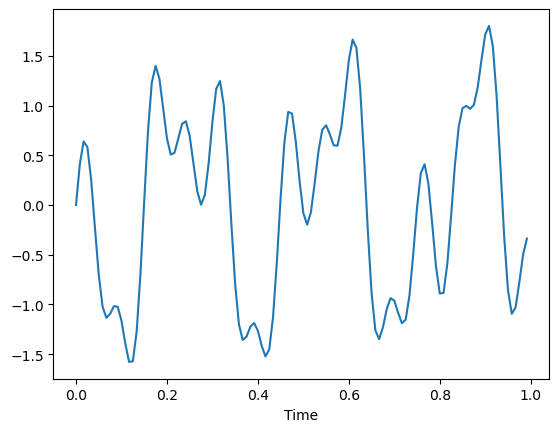

In [24]:
plt.plot(observations, target);
plt.xlabel("Time");

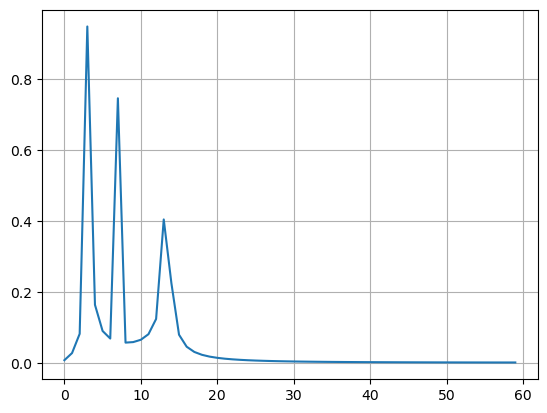

In [25]:
N = observation_resolution
T = 1.0 / N
yf = sp.fft.fft(target)
xf = sp.fft.fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]));
plt.grid();
# plt.xlim(70, 72);

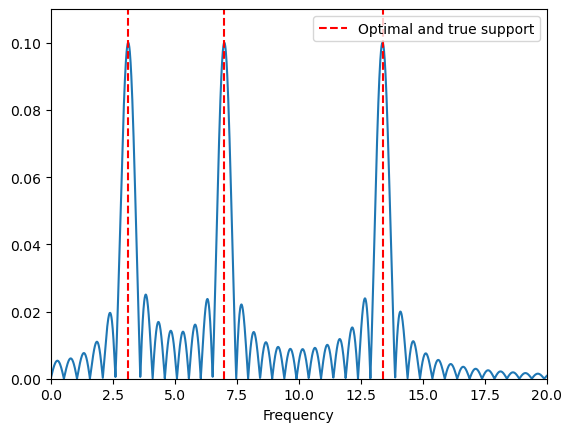

In [42]:
u_tilde = u #Measure([[6]], [0.1])
a = np.arange(Omega[0][0],Omega[0][1],0.01)
vals = np.array([np.abs(p(u_tilde)(np.array([x]))) for x in a])
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.axvline(x=pos, linestyle="--", c="r", label="Optimal and true support");
    else:
        plt.axvline(x=pos, linestyle="--", c="r");
plt.xlabel("Frequency");
plt.ylim(0,0.11);
plt.xlim(0, 20);
plt.legend();

In [ ]:
residuals_exact = np.array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388041e-02,
       1.50239775e-02, 8.58376250e-03, 6.60215203e-03, 6.26160456e-03,
       5.81056957e-03, 5.68714553e-03, 5.63453913e-03, 2.74798167e-03,
       2.49625306e-03, 2.43692854e-03, 1.09428955e-03, 1.06241337e-03,
       9.64583833e-04, 3.70010644e-04, 3.28227685e-04, 3.27716476e-04,
       1.08225416e-04, 8.89059449e-05, 8.85996743e-05, 2.08580990e-05,
       1.15859851e-05, 1.14112334e-05, 8.58446277e-06, 4.06824298e-06,
       3.96465252e-06, 2.55842179e-06, 1.39500446e-06, 1.33895724e-06,
       6.37731117e-07, 3.72191473e-07, 3.43279092e-07, 1.86417351e-07,
       1.07770816e-07, 9.30293274e-08, 4.47909070e-08, 3.13019381e-08,
       2.38731512e-08, 1.63320804e-08, 9.87066068e-09, 6.13812898e-09,
       2.36235467e-09, 2.29300559e-09, 4.22733681e-10, 3.32151223e-10,
       2.96477898e-10, 1.96942879e-10, 1.51313462e-10, 1.33165673e-10,
       8.31087976e-11, 6.02094763e-11, 5.10579357e-11, 2.59572364e-11,
       1.44861345e-11, 9.89086590e-12, 6.27772834e-12, 4.28576619e-12,
       3.35928507e-12, 1.54884439e-12])

times_exact = np.array([4.76837158e-07, 1.79091358e+00, 4.63218451e+00, 8.61019373e+00,
       1.33250959e+01, 2.00208039e+01, 2.82773757e+01, 3.71967793e+01,
       4.76729791e+01, 6.08036323e+01, 7.60165074e+01, 8.99167523e+01,
       1.02628252e+02, 1.13188138e+02, 1.23412420e+02, 1.31921410e+02,
       1.40766542e+02, 1.46520566e+02, 1.53597552e+02, 1.61834399e+02,
       1.68161059e+02, 1.75628953e+02, 1.82925129e+02, 1.89845630e+02,
       1.96949499e+02, 2.04053355e+02, 2.11450971e+02, 2.18952193e+02,
       2.26065537e+02, 2.33662433e+02, 2.40761266e+02, 2.47927532e+02,
       2.55171696e+02, 2.62040714e+02, 2.68780920e+02, 2.75913649e+02,
       2.83087280e+02, 2.90807017e+02, 2.97894469e+02, 3.05639237e+02,
       3.12655720e+02, 3.20072694e+02, 3.27330058e+02, 3.34243673e+02,
       3.41363409e+02, 3.48102313e+02, 3.55088551e+02, 3.62413532e+02,
       3.69843481e+02, 3.76928904e+02, 3.83821238e+02, 3.90807865e+02,
       3.97644762e+02, 4.04461159e+02, 4.11549827e+02, 4.18810709e+02,
       4.25975578e+02, 4.33159965e+02, 4.40110868e+02, 4.46986418e+02,
       4.54572302e+02, 4.61915079e+02])

supports_exact = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6])

residuals_newton = np.array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388041e-02,
       4.42212683e-07, 3.05311332e-16, 0.00000000e+00, 0.00000000e+00])

times_newton = np.array([9.53674316e-07, 1.19265723e+00, 3.00789595e+00, 6.15335083e+00,
       1.00565565e+01, 1.35182316e+01, 1.71628146e+01, 1.71777303e+01])

supports_newton = np.array([0, 1, 2, 3, 3, 3, 3, 3])

residuals_newton_damped = np.array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388041e-02,
       3.08850641e-02, 1.82090781e-02, 9.97240230e-03, 4.95807835e-03,
       2.16109594e-03, 7.80550619e-04, 2.11713861e-04, 3.56665636e-05,
       2.46933184e-06, 2.60225190e-08, 4.23355795e-12, 0.00000000e+00,
       0.00000000e+00])

times_newton_damped = np.array([2.38418579e-07, 1.03951383e+00, 2.75495601e+00, 5.30796885e+00,
       9.12362576e+00, 1.27442422e+01, 1.65395997e+01, 2.03141606e+01,
       2.41402617e+01, 2.81297948e+01, 3.20747194e+01, 3.57663283e+01,
       3.94907434e+01, 4.33421445e+01, 4.66991813e+01, 4.99720948e+01,
       5.37529144e+01])

supports_newton_damped = np.array([0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

residuals_lpdap = np.array([5.26929402e+01, 5.26929402e+01, 2.22757014e+01, 7.51575796e+00,
       4.94388041e-02, 1.50239775e-02, 1.50239775e-02, 1.50239775e-02,
       8.58376730e-03, 8.58376730e-03, 6.60215359e-03, 6.60215359e-03,
       6.60215359e-03, 6.60215359e-03, 6.26160538e-03, 5.81057030e-03,
       5.81057030e-03, 5.68714588e-03, 5.68714588e-03, 5.63453938e-03,
       5.63453938e-03, 5.63453938e-03, 2.74798132e-03, 2.74798132e-03,
       2.49625271e-03, 2.49625271e-03, 2.49625271e-03, 2.43692817e-03,
       2.43692817e-03, 1.09428945e-03, 1.06241338e-03, 1.06241338e-03,
       1.06241338e-03, 9.64583841e-04, 9.64583841e-04, 9.64583841e-04,
       9.64583841e-04, 3.70010649e-04, 3.70010649e-04, 3.70010649e-04,
       3.28227689e-04, 3.27716480e-04, 3.27716480e-04, 3.27716480e-04,
       1.08225418e-04, 1.08225418e-04, 1.08225418e-04, 8.89059465e-05,
       8.89059465e-05, 8.85996759e-05, 8.85996759e-05, 2.08580992e-05,
       1.15859850e-05, 1.14112333e-05, 8.58446270e-06, 4.06824279e-06,
       3.96465233e-06, 2.55842179e-06, 1.39500432e-06, 1.33895711e-06,
       6.37731073e-07, 3.72191462e-07, 3.43279081e-07, 9.30392290e-08,
       2.38696606e-08, 1.63321841e-08, 9.87003840e-09, 6.13741485e-09,
       2.36343761e-09, 2.29458103e-09, 4.24262708e-10, 3.32615852e-10,
       2.97188774e-10, 1.97625583e-10, 8.33679792e-11, 2.60046706e-11,
       1.44018963e-11, 9.83751969e-12, 3.35639849e-12, 2.48856491e-13,
       1.08024700e-13, 5.50393064e-14])

times_lpdap = np.array([2.38418579e-07, 9.16587114e-01, 2.59622550e+00, 5.43256545e+00,
       9.21879196e+00, 1.43513534e+01, 1.93465788e+01, 2.43550189e+01,
       3.08019955e+01, 3.72280843e+01, 4.50078251e+01, 5.30768378e+01,
       6.16629486e+01, 7.01597121e+01, 7.96252964e+01, 9.03486829e+01,
       1.01371298e+02, 1.15134366e+02, 1.28140696e+02, 1.43014188e+02,
       1.57223959e+02, 1.71999042e+02, 1.84351384e+02, 1.97305848e+02,
       2.10741424e+02, 2.24112782e+02, 2.37687583e+02, 2.48140408e+02,
       2.58966945e+02, 2.67586677e+02, 2.76761493e+02, 2.85518861e+02,
       2.94715651e+02, 3.03175674e+02, 3.11757894e+02, 3.20496978e+02,
       3.28968448e+02, 3.34686707e+02, 3.40432468e+02, 3.46168219e+02,
       3.52014356e+02, 3.59252683e+02, 3.66360662e+02, 3.73975780e+02,
       3.80126110e+02, 3.86312181e+02, 3.92376385e+02, 3.99600648e+02,
       4.06923001e+02, 4.13880958e+02, 4.20909967e+02, 4.27959984e+02,
       4.35355516e+02, 4.43047293e+02, 4.50735886e+02, 4.57791246e+02,
       4.65550937e+02, 4.72995989e+02, 4.80205695e+02, 4.88013232e+02,
       4.95799445e+02, 5.03054562e+02, 5.10678798e+02, 5.18249248e+02,
       5.26493312e+02, 5.34053210e+02, 5.42172255e+02, 5.50052605e+02,
       5.57481351e+02, 5.64819668e+02, 5.71826191e+02, 5.78811411e+02,
       5.86422425e+02, 5.94175051e+02, 6.01025346e+02, 6.08476599e+02,
       6.16341784e+02, 6.23837200e+02, 6.30829304e+02, 6.37764230e+02,
       6.44911931e+02, 6.51940377e+02])

supports_lpdap = np.array([ 0,  0,  1,  2,  3,  4,  4,  4,  5,  5,  6,  6,  6,  6,  7,  8,  8,
        9,  9, 10, 10, 10,  9,  9,  9,  9,  9,  8,  8,  7,  7,  7,  7,  7,
        7,  7,  7,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6])

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
for array, name, style in zip([residuals_exact, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-12, 527);
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
for array, name, style in zip([supports_exact, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
for domain, array, name, style in zip([times_exact, times_lpdap, times_newton, times_newton_damped], [residuals_exact, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-12, 26);
plt.legend();